## The Forward model

In [1]:
import os, sys, inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from brian2 import *
from matplotlib import pyplot as plt
import Documentation.parameters as p
from Foundations.helpers import scale_input_theory, make_spiketrain
from Foundations.MI import analyze_exp
import pandas as pd

INFO       Cache size for target "cython": 1631 MB.
You can call "clear_cache('cython')" to delete all files from the cache or manually delete files in the "C:\Users\laure\.cython\brian_extensions" directory. [brian2]


In [3]:
from Old_testing.make_dynamic_experiment_ori import make_dynamic_experiments
from Old_testing.currentmodel import Barrel_PC, Barrel_IN

In [4]:
defaultclock = p.dt*ms
np.random.seed()
seed = np.random.randint(1000000000)

In [5]:
[input_theory, hidden_state] = make_dynamic_experiments(p.qon_qoff_type, p.baseline, p.tau, p.factor_ron_roff, p.mean_firing_rate, p.sampling_rate, p.duration)

inj_current = scale_input_theory(input_theory, 0, 17, p.dt)

[]

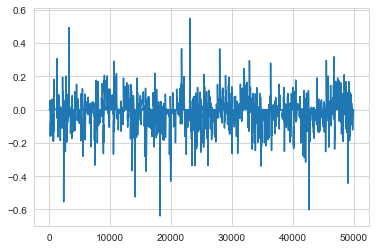

In [6]:
plt.plot(input_theory)

plt.plot()

In [7]:
start_scope()
IN = Barrel_IN(p.dt, inj_current)

IN_neuron = IN.getNeurongroup()

IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(IN_neuron, 'v', record = True)

run(p.duration*ms)

NameError: name 'scale' is not defined

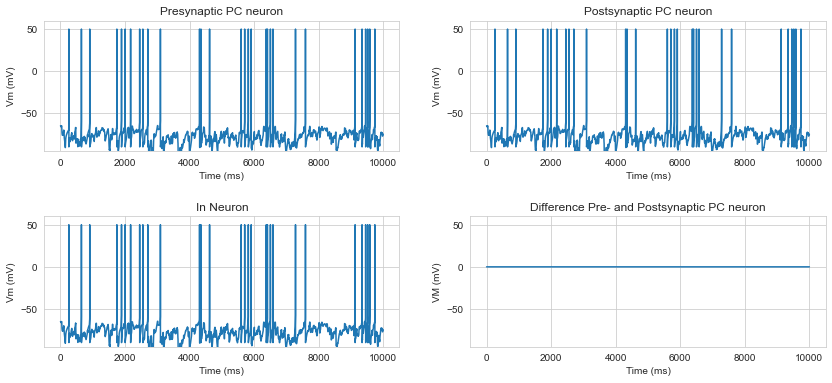

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(14,6))
fig.subplots_adjust(hspace=0.5)
axs[0, 0].plot(IN_M.t/ms, IN_M.v[0]*1000, label= 'PC SM (pre)')
axs[0, 0].set_ylim([-95, 60])
axs[0, 0].set(ylabel='Vm (mV)', xlabel='Time (ms)', title='Presynaptic PC neuron')

axs[0, 1].plot(IN_M.t/ms, IN_M.v[0]*1000, label= 'PC SM (post)')
axs[0, 1].set(ylabel='Vm (mV)', xlabel='Time (ms)', title='Postsynaptic PC neuron')
axs[0, 1].set_ylim([-95, 60])
axs[0, 1].set_title('Postsynaptic PC neuron')

axs[1, 0].plot(IN_M.t/ms, IN_M.v[0]*1000, label= 'IN SM')
axs[1, 0].set(ylabel='Vm (mV)', xlabel='Time (ms)', title='In Neuron')
axs[1, 0].set_ylim([-95, 60])
axs[1, 0].set_title('In Neuron')

axs[1, 1].plot(IN_M.t/ms, IN_M.v[0]*1000 - IN_M.v[0]*1000, label= 'PC Spike')
axs[1, 1].set_ylim([-95, 60])
axs[1, 1].set(ylabel='VM (mV)', xlabel='Time (ms)', title='Difference Pre- and Postsynaptic PC neuron')

fig.suptitle('State Monitors, Scale: '+ str(scale) + ' Weight: ' + str(weight))

plt.show()

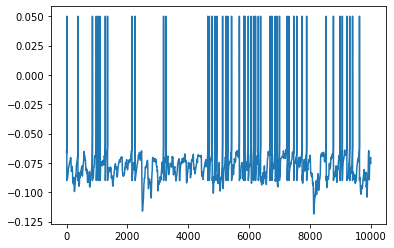

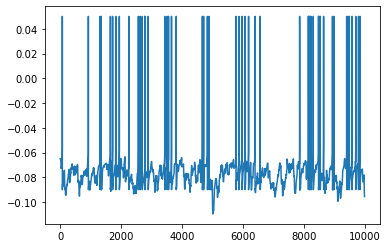

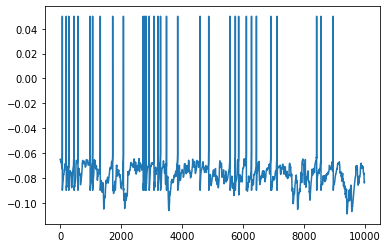

In [29]:
plot(IN_M.t / ms, IN_M.v[0], label='IN_pre')

## Analyzing the network

In [ ]:
start_scope()
#Initialising the neuron classes
PC = Barrel_PC(p.dt, inj_current)
IN = Barrel_IN(p.dt, inj_current)
#Getting the neuron groups
PC_neuron = PC.getNeurongroup()
IN_neuron = IN.getNeurongroup()

net2 = Network(PC_neuron,
               IN_neuron)

PC_M = StateMonitor(PC_neuron, 'v', record=True)
PC_S = SpikeMonitor(PC_neuron, 'v', record = True)
IN_M = StateMonitor(IN_neuron, 'v', record=True)
IN_S = SpikeMonitor(PC_neuron, 'v', record = True)

net2.add(PC_M, IN_M, PC_S, IN_S)
#getting all the parameters for in the synapse
delay = 0.6

syn2 = Synapses(IN_neuron, PC_neuron, on_pre='''v_post += w*mV''', delay= delay*ms, dt=p.dt * ms)
syn2.connect(i=0, j=1)
net2.add(syn2)

net2.store()

output_PC = pd.DataFrame()
output_IN = pd.DataFrame()
weights = np.arange(1,20,0.5)
samples = p.duration/p.dt

for w in weights:
    net2.restore()
    w = w
    label = str(w)
    net2.run(p.duration*ms)
    spiketrain = make_spiketrain(PC_S)

    fig, axs = plt.subplots(2, 2, figsize=(14,6))

    axs[0, 0].plot(PC_M.t/ms, PC_M.v[0], label= 'PC SM (pre)')
    axs[0,0].legend()
    axs[0, 1].plot(PC_M.t/ms, PC_M.v[1], label= 'PC SM (post)')
    axs[0,1].legend()

    axs[1, 0].plot(IN_M.t/ms, IN_M.v[0], label= 'IN SM')
    axs[1, 0].set_title('Statemonitor IN SM')

    axs[1, 1].plot(PC_M.t/ms, PC_M.v[1] - PC_M.v[0], label= 'PC Spike')
    axs[1, 1].set_title('Difference in state between the pre and post neuron')



    fig.suptitle('State Monitors')
    fig.legend()
    plt.show()

    output_PC = pd.concat([output_PC, analyze_exp(hidden_state, input_theory,0, spiketrain,samples, w)], axis = 0)
    output_IN = pd.concat([output_IN, analyze_exp(hidden_state, input_theory, 0, spiketrain, p.duration/p.sampling_rate, w)], axis =0)

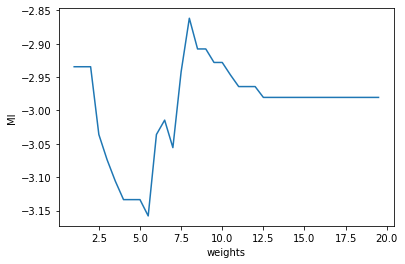

In [67]:
plt.figure()
plt.plot(weights, output_PC['MI'])
plt.xlabel('weights')
plt.ylabel('MI')
plt.show()

In [65]:
output_IN

,weigts,Hxx,Hxy,MI_i,xhat_i,MSE_i,MI,qon,qoff,xhatspikes,MSE,F,F_I
0,1.0,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-2.934643,0.001778,0.000495,"[0.3333333333333333, 0.2790864953977537, 0.230...",9.821225,0.190592,-15.920956
0,1.5,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-2.934643,0.001778,0.000495,"[0.3333333333333333, 0.2790864953977537, 0.230...",9.821225,0.190592,-15.920956
0,2.0,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-2.934643,0.001778,0.000495,"[0.3333333333333333, 0.2790864953977537, 0.230...",9.821225,0.190592,-15.920956
0,2.5,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.036156,0.002286,0.000495,"[0.3333333333333333, 0.26908688071151327, 0.21...",9.82455,0.190592,-16.471683
0,3.0,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.073849,0.00254,0.000495,"[0.3333333333333333, 0.2649626581243451, 0.206...",9.825641,0.190592,-16.676171
0,3.5,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.105916,0.002794,0.000495,"[0.3333333333333333, 0.26126685482851153, 0.20...",9.826513,0.190592,-16.850143
0,4.0,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.13369,0.003048,0.000495,"[0.3333333333333333, 0.25792208308031644, 0.19...",9.82723,0.190592,-17.000821
0,4.5,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.13369,0.003048,0.000495,"[0.3333333333333333, 0.25792208308031644, 0.19...",9.82723,0.190592,-17.000821
0,5.0,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.13369,0.003048,0.000495,"[0.3333333333333333, 0.25792208308031644, 0.19...",9.82723,0.190592,-17.000821
0,5.5,0.967121,0.782795,0.184326,"[0.3333333333333333, 0.3333333333333333, 0.333...",4.466088,-3.158093,0.003302,0.000495,"[0.3333333333333333, 0.25486996881436746, 0.18...",9.827832,0.190592,-17.133211


In [66]:
weights = np.arange(1,20, 0.5)
weights

array([ 1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,  6. ,
        6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. , 11.5,
       12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5, 17. ,
       17.5, 18. , 18.5, 19. , 19.5])